# Prediction Project - Playlist Recommendation

### Adam McWilliams

In [64]:
import pandas as pd
import json
import os
import spotipy
import scipy.stats as stats
from spotipy.oauth2 import SpotifyOAuth
import matplotlib.pyplot as plt
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
import time
import requests
import seaborn as sb


# Set your Spotify API credentials
os.environ["SPOTIPY_CLIENT_ID"] = "ac3a06f88c94438e904e5fb6f4cd19b9"
os.environ["SPOTIPY_CLIENT_SECRET"] = "da619d1d04794e4cab338a691146fbbd"

# Create a Spotify client
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

# Project Topic

---

### Explanation:

<p>
For my project I am going to be taking on the problem of prediction. I am making a playlist recommendation system where a user will be able to input an array of tracks and the model will output a list of tracks that it “thinks” are similar. There are two different filtering approaches I will use to attain my goal. 
</p>

<p>
The first is Collaborative filtering. In this approach the model recommends different tracks that occur with most frequency from the various playlists that contain the same tracks inputed by the user. In this approach there are no features about the input tracks themselves that we are using to find similarity between our output tracks. Instead we are deriving similarity based on the fact that if other people have our desired tracks in their playlists then the other songs in that playlist are probably similar and fall under a similar taste.

</p>
The second approach I will be using is Content based filtering. With this method we are using features about the tracks themselves to recommend tracks that are similar. I will be using features such as tempo, acousticness, valence … to derive similarity between the tracks. 
</p>

<p>
For both of these methods I will be using the K-Nearest-Neighbor algorithm to measure similarity between the input and output tracks. I will be using cosine or Pearsons correlation to measure the distance between the vectors.
</p>

### Goal:
<p>
For this project I hope to gain more insight into the datascience techniques that go into recommendation systems. I hope to have a solid grasp on how to prepare my data for both filtering methods and how to implement the K Nearest Neighbors algorithm.
</p>

---

## Data 

For my training data I am using the Spotify Million Playlist Dataset. The Data is a set of a million different playlists each containing a set of at most 250 tracks created by users of the Spotify platform. I obtained the dataset from aicrowd.com https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge.

The data is divided into 1000 different slice files. Each file contains 1000 playlists. The size of each slice is on average 32 MB. I will most likely not be using all one million playlists because of computational limits of the model and APIs I use to fetch additional features below. The beauty of this dataset is that I can control how many slices I want to use. For this initial stage I am only using 1 slice file. Which contains 67,500 rows. I'm converting the JSON filetype into a tabulated dataframe. The features I am using in the initial dataset are:

- Artist (String)
- Track (String)
- Track ID - The unique identifier for the track in the spotify database (string)
- Artist ID - The unique identifier for the track's artist in the spotify database (String)
- Playlist ID - The unique identifier for the parcular playlist in the dataset. (String)

I will be using API's later in my data curation below to fetch more unique features for each track. I will be extending the features to include:

- Popularity - Spotify metric describing popularity of a track (Int)
- Danceability - Spotify metric describing danceability of track (FLoat)
- Valence - Spotify metric describing the positivity or happiness of a track (Float)
- Energy - Spotify metric measuring intensity and activity of a track (Float)
- Instrumentalness - Spotify metric measuring likelihood of track being an instrumental (Float)
- Liveness - Spotify metric recording the likelihood of a audience in the track (Float)
- Speechiness- Spotify metric recording the amount of spoken word in a track (FLoat)
- Tempo - :The BPM (beats per minute) of a track (Int)

---

The code below downloads the specified n number of slices, pulls each track and the first 5 features of the track specified above, and converts the JSON data into a dataframe. Each item is unique based on it's Track ID and Playlist ID.

In [65]:

tracks = pd.DataFrame()

n = 1  # Change this to the number of files you have
for i in range(0, n*1000, 1000):
    filename = f"spotify_million_playlist_dataset/data/mpd.slice.{i}-{i+999}.json"
    
    with open(filename, "r") as f:
        data = json.load(f)

    update_tracks = []
    playlists = pd.json_normalize(data, record_path="playlists")
    
    for _, playlist in playlists.iterrows():
        for track in playlist["tracks"]:
            track["pid"] = playlist["pid"]
            update_tracks.append(track)

    tracks = tracks.append(pd.DataFrame(update_tracks), ignore_index=True)

/tmp/ipykernel_17103/216614870.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracks = tracks.append(pd.DataFrame(update_tracks), ignore_index=True)


In [66]:

data = pd.DataFrame({"Artist" : tracks["artist_name"], 
                            "Artist_ID": tracks["artist_uri"].apply(lambda x : x.split("spotify:artist:")[1]),
                            "Track" : tracks["track_name"],
                            "Track_ID": tracks["track_uri"].apply(lambda x : x.split("spotify:track:")[1]),
                            "Playlist ID": tracks["pid"]})

In [62]:
data.head()

,Artist,Artist_ID,Track,Track_ID,Playlist ID
0,Missy Elliott,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),0UaMYEvWZi0ZqiDOoHU3YI,0
1,Britney Spears,26dSoYclwsYLMAKD3tpOr4,Toxic,6I9VzXrHxO9rA9A5euc8Ak,0
2,Beyoncé,6vWDO969PvNqNYHIOW5v0m,Crazy In Love,0WqIKmW4BTrj3eJFmnCKMv,0
3,Justin Timberlake,31TPClRtHm23RisEBtV3X7,Rock Your Body,1AWQoqb9bSvzTjaLralEkT,0
4,Shaggy,5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,1lzr43nnXAijIGYnCT8M8H,0


--- 

Now we have a dataframe that can be used for the collaborative based filtering method. However, there are not enough features for content based filtering. For this I will need some way to collect unique features of each track. The functions defined below use the Spotipy library to accomplish this. The Spotipy library methods send an API call to different Spotify Developer API endpoints returning the popularity metric and unique audio feature values for each track in the dataframe. These are the same features that spotify utilize in their recommendation systems. The process of fetching features with API's is not related to the class so I will spare the details.



In [67]:
import time
import requests

def get_features(func_type, feature_type, ids):
    def fetch_features(batch_ids, max_retries=3, backoff_factor=2):
        retries = 0
        while retries <= max_retries:
            try:
                response = func_type(batch_ids)
                return response
            except requests.exceptions.RequestException as e:
                if retries < max_retries:
                    sleep_time = backoff_factor * (2 ** retries)
                    time.sleep(sleep_time)
                    retries += 1
                else:
                    raise e

    features = {}
    if feature_type == "audio_features":
        for i in range(0, len(ids), 50):
            batch_ids = ids[i:i + 50]
            batch_features = fetch_features(batch_ids)

            for feature in batch_features:
                if feature is not None:
                    features[feature['id']] = feature
    else:
        for i in range(0, len(ids), 50):
            batch_ids = ids[i:i + 50]
            batch_features = fetch_features(batch_ids)

            for feature in batch_features[feature_type]:
                if feature is not None:
                    features[feature['id']] = feature

    return features

--- 

In the code below I am calling my get_features method to fetch the Popularity metric. This will return a python dictionary of track Id (key) and popularity metric (value) for each track in my data. I am also fetching my audio features as well, this will also return a dictionary of all the audio features for each track.

In [72]:
#Get the popularity of each track
track_ids = data["Track_ID"].drop_duplicates().reset_index(drop=True)
track_features = get_features(sp.tracks, 'tracks', track_ids)
track_ids = [track_id for track_id in track_features.keys()]
popularity_df = pd.DataFrame({"Track_ID": [track_id for track_id in track_features.keys()],
                                "Popularity": [track_features[track_id]["popularity"] for track_id in track_ids]})

In [74]:
#Get the audio features of each track
audio_features = get_features(sp.audio_features, 'audio_features', track_ids)
audio_feature_typ = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "tempo", "valence"]
audio_features_df = pd.DataFrame({"Track_ID": track_ids})
for feature in audio_feature_typ:
    audio_features_df[feature] = [audio_features[track_id][feature] for track_id in track_ids]



Now we have two intermediate dataframes that hold the the popularity metrics and audio features. We can move onto merging and cleaning the data in the dataframe.

---


# Data Cleaning

In my get_features method, if for some reason a track ID I used to fetch a feature does not exist in the spotify database then that track will be rejected and will not be included in the dataframes holding the features.  This presents a problem when I merge them back into my main dataframe. Specifically there will be certain tracks in the main dataframe that do not exist in the features dataframes creating Null values. I have printed the rows that match this case containing null values below. We will just drop any tracks with null values from the dataframe and will not use them in our model. Since there are so many songs in each playlist dropping a few songs won't make much of a difference.

In [ ]:
data = data.merge(popularity_df, on="Track_ID", how="left")
data = data.merge(audio_features_df, on="Track_ID", how="left")

In [45]:
null_rows = data[data.isnull().any(axis=1)]
null_rows

,Artist,Artist_ID,Track,Track_ID,Playlist ID,Popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
33255,Son Palenque,3VyjbWEHPjc9JEXsk6Tk2w,Palenque Palenque,656TZlNdVe90zHvmebFt9U,497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52383,Coldplay,4gzpq5DPGxSnKTe4SA8HAU,Adventure of a Lifetime,5GiU7GOYjDH2yp7fMf9w9j,782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
data = data.dropna()
data

,Unnamed: 0.1,Unnamed: 0,Artist,Artist_ID,Track,Track_ID,Playlist ID,Popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0,0,Missy Elliott,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),0UaMYEvWZi0ZqiDOoHU3YI,0,1.110242,-0.735076,1.841753,0.811697,-0.242390,-0.918669,0.030758,0.243002,0.132102,1.319095
1,1,1,Missy Elliott,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),0UaMYEvWZi0ZqiDOoHU3YI,123,1.110242,-0.735076,1.841753,0.811697,-0.242390,-0.918669,0.030758,0.243002,0.132102,1.319095
2,2,2,Missy Elliott,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),0UaMYEvWZi0ZqiDOoHU3YI,218,1.110242,-0.735076,1.841753,0.811697,-0.242390,-0.918669,0.030758,0.243002,0.132102,1.319095
3,3,3,Missy Elliott,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),0UaMYEvWZi0ZqiDOoHU3YI,342,1.110242,-0.735076,1.841753,0.811697,-0.242390,-0.918669,0.030758,0.243002,0.132102,1.319095
4,4,4,Missy Elliott,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),0UaMYEvWZi0ZqiDOoHU3YI,382,1.110242,-0.735076,1.841753,0.811697,-0.242390,-0.918669,0.030758,0.243002,0.132102,1.319095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67496,67496,67496,Jon D,5HCypjplgh5uQezvBpOfXN,I Don't Know,3uCHI1gfOUL5j5swEh0TcH,999,-0.458204,2.017097,0.375762,-1.998409,0.089212,-0.613591,-1.393190,-0.264409,-1.338308,-0.396603
67497,67497,67497,Big Words,0sHN89qak07mnug3LVVjzP,The Answer,0P1oO2gREMYUCoOkzYAyFu,999,0.053246,-0.531801,-0.722172,0.398588,-0.282219,-0.390427,0.619763,1.179761,-1.676657,-0.871784
67498,67498,67498,Allan Rayman,6Yv6OBXD6ZQakEljaGaDAk,25.22,2oM4BuruDnEvk59IvIXCwn,999,0.496503,0.353278,0.581624,-0.576543,0.033783,0.699598,-0.993042,-0.163903,0.638950,-0.972707
67499,67499,67499,Jon Jason,77bNdkKYBBmc30CisCA6tE,Good Feeling,4Ri5TTUgjM96tbQZd5Ua7V,999,-0.765074,0.606468,-0.622360,-1.719800,-0.282153,-0.377527,-2.132428,0.262518,-0.000536,-0.997938


In [53]:
data.to_csv("spotify_million_playlist_dataset/transformed_data/data.csv")

---

We now have a clean dataset with enough features. We can mainipulate the data further to work with both filtering methods. However there is still another problem. Many of our features are on different scales ranging from different sets of values. Because KNN measures similarity based on distance, if the features are on different scales this can cause serious performance problems and give incorrect results.

To solve this problem I will standardized all my features to have a mean of 0 and std of 1.

In [73]:
data = pd.read_csv('spotify_million_playlist_dataset/transformed_data/data.csv')

In [75]:
def standardize(data):
    return (data - np.mean(data)) / np.std(data)

In [76]:
col_to_standardize = ['Popularity', 'danceability', 'tempo', 'loudness', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
for col in col_to_standardize:
    data[col] = standardize(data[col])



In [83]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Artist,Artist_ID,Track,Track_ID,Playlist ID,Popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0,0,Missy Elliott,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),0UaMYEvWZi0ZqiDOoHU3YI,0,1.110242,-0.735076,1.841753,0.811697,-0.24239,-0.918669,0.030758,0.243002,0.132102,1.319095
1,1,1,Missy Elliott,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),0UaMYEvWZi0ZqiDOoHU3YI,123,1.110242,-0.735076,1.841753,0.811697,-0.24239,-0.918669,0.030758,0.243002,0.132102,1.319095
2,2,2,Missy Elliott,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),0UaMYEvWZi0ZqiDOoHU3YI,218,1.110242,-0.735076,1.841753,0.811697,-0.24239,-0.918669,0.030758,0.243002,0.132102,1.319095
3,3,3,Missy Elliott,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),0UaMYEvWZi0ZqiDOoHU3YI,342,1.110242,-0.735076,1.841753,0.811697,-0.24239,-0.918669,0.030758,0.243002,0.132102,1.319095
4,4,4,Missy Elliott,2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),0UaMYEvWZi0ZqiDOoHU3YI,382,1.110242,-0.735076,1.841753,0.811697,-0.24239,-0.918669,0.030758,0.243002,0.132102,1.319095


## EDA

There is one last problem to take care of in the dataset. There may be features that are correlated to eachother. This can cause problems when running KNN because correlated features may reinforce eachother causing biases and creating performance issues. I have decided to create a correlation matrix and describe it with a heatmap. This will show the correlations between all the features to test for multicollinearity.

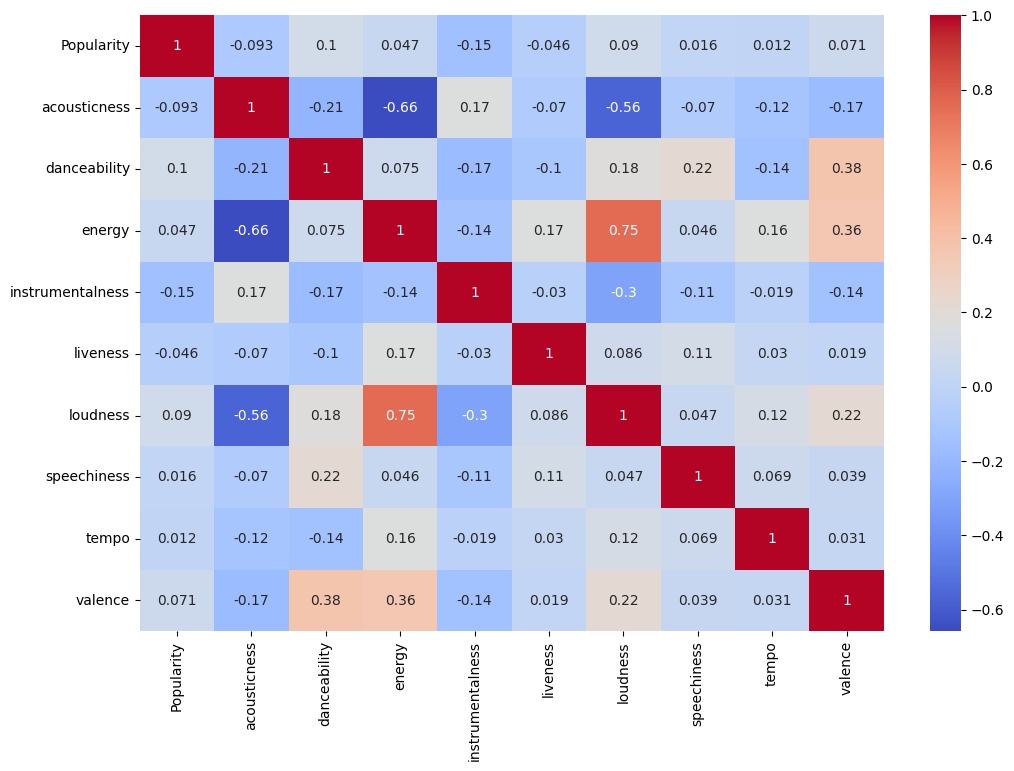

In [81]:
corr_matrix = data.drop(['Artist', 'Track', 'Artist_ID', 'Track_ID', 'Playlist ID', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1).corr()


plt.figure(figsize=(12, 8))

sb.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

Based on this analyses I will most likely drop loudness as this feature is highly correlated with energy and moderately correlated with acousticness. I feel as though loudness is not as important of a feature when reccomending tracks.